In [1]:
import tensorflow as tf
import numpy as np
import cv2
import random
import pathlib
from tqdm import tqdm
import os

import einops
#import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import layers


In [2]:
# import tensorflow as tf

# # Limpar o gráfico padrão
# tf.keras.backend.clear_session()

# # Configurar GPUs
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.set_visible_devices(gpus[1], 'GPU')  # Use apenas GPU:0
#         tf.config.experimental.set_memory_growth(gpus[1], True)  # Habilitar crescimento de memória
#     except RuntimeError as e:
#         print(f"Erro ao configurar GPUs: {e}")


## Pré-Processamento dos vídeos

In [3]:
def format_frames(frame, output_size=(224, 224)):
    """
    Redimensiona e normaliza os frames.

    Args:
        frame: Frame (imagem) a ser processado.
        output_size: Tamanho de saída (height, width).

    Return:
        Frame formatado e normalizado.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)  # Normaliza entre [0, 1]
    frame = tf.image.resize_with_pad(frame, *output_size)  # Redimensiona com padding
    return frame


def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Extrai frames de um vídeo específico.

    Args:
        video_path: Caminho completo do vídeo.
        n_frames: Número de frames a extrair.
        output_size: Tamanho de cada frame (altura, largura).
        frame_step: Número de frames a pular entre capturas.

    Return:
        NumPy array com frames no formato (n_frames, altura, largura, canais).
    """
    result = []
    cap = cv2.VideoCapture(str(video_path))
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start)

    for i in range(n_frames):
        for _ in range(frame_step):
            ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, output_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            result.append(frame)
        else:
            result.append(np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8))

    cap.release()
    return np.array(result)


## Classe Geradora de Dados (FrameGenerator)

In [4]:
# Considerar os primeiros 312 frames (10s)
class FrameGenerator:
    def __init__(self, path, n_frames=448, training=False):
        """
        Inicializa o gerador de frames para vídeos em um dataset.

        Args:
            path: Caminho raiz para os diretórios de vídeos organizados por classe.
            n_frames: Número de frames a extrair por vídeo.
            training: Define se é para treinamento (embaralha os dados).
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = ["High pain", "Low pain", "Rest", "Baseline"]
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        """
        Busca todos os vídeos no caminho base e identifica suas classes.
        """
        video_paths = []
        classes = []

        # Percorre a estrutura do dataset
        for video_folder in self.path.glob("video/*"):
            if video_folder.is_dir():
                for video_file in video_folder.glob("*.mp4"):
                    video_name = video_file.name
                    if "Pain_HIGH" in video_name:
                        classes.append("High pain")
                    elif "Pain_LOW" in video_name:
                        classes.append("Low pain")
                    elif "Rest" in video_name:
                        classes.append("Rest")
                    elif "Baseline" in video_name:
                        classes.append("Baseline")
                    video_paths.append(video_file)

        return video_paths, classes

    def __call__(self):
        """
        Gera os frames e rótulos a partir dos vídeos.
        """
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)  # Extrai frames
            label = self.class_ids_for_name[name]  # Converte rótulo para ID
            yield video_frames, label


In [5]:
def create_dataset(video_dir, batch_size=4, n_frames=448, training=False):
    """
    Cria um `tf.data.Dataset` para o treinamento ou avaliação.

    Args:
        video_dir: Caminho para o diretório contendo os vídeos.
        batch_size: Tamanho do batch.
        n_frames: Número de frames por vídeo.
        training: Define se é um dataset de treinamento.

    Return:
        Um `tf.data.Dataset` pronto para uso.
    """
    video_dir = pathlib.Path(video_dir)

    frame_generator = FrameGenerator(video_dir, n_frames, training=training)

    output_signature = (
        tf.TensorSpec(shape=(n_frames, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )

    dataset = tf.data.Dataset.from_generator(
        frame_generator,
        output_signature=output_signature
    )

    if training:
        dataset = dataset.shuffle(100, reshuffle_each_iteration=True)
        
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [6]:
TRAIN_PATH = pathlib.Path("./Train")
VAL_PATH = pathlib.Path("./Validation")

In [7]:
# Configurações do dataset
batch_size = 4
n_frames = 448

# Criação dos datasets
train_dataset = create_dataset(TRAIN_PATH, batch_size, n_frames, training=True)
val_dataset = create_dataset(VAL_PATH, batch_size, n_frames, training=False)

# Iterando sobre o dataset para verificar os dados
for video_batch, label_batch in train_dataset.take(1):
    print(f"Batch de vídeos shape: {video_batch.shape}")
    print(f"Batch de labels: {label_batch}")



Batch de vídeos shape: (4, 448, 224, 224, 3)
Batch de labels: [2 2 2 2]


### Visualizar frames

In [8]:
# import matplotlib.pyplot as plt

# for video_batch, label_batch in train_dataset.take(1):
#     for i in range(video_batch.shape[0]):  # Itera sobre os vídeos no batch
#         video = video_batch[i].numpy()  # Converte para numpy
#         label = label_batch[i].numpy()

#         print(f"Vídeo {i+1}, Classe: {label}")
#         for frame_idx in range(video.shape[0]):  # Itera pelos frames do vídeo
#             plt.imshow(video[frame_idx].astype("uint8"))
#             plt.title(f"Frame {frame_idx+1} - Classe: {label}")
#             plt.axis("off")
#             plt.show()


Importante: Ajustar pre processamento para evitar quadros pretos quando o video acabar, depois passar para a criação do modelo

### Criação do modelo ###

In [9]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [10]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [11]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [12]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [13]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [14]:
HEIGHT = 224
WIDTH = 224
input_shape = (None, 448, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [15]:
frames, label = next(iter(train_dataset))
model.build(frames)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 224, 2  0           []                               
                                24, 3)]                                                           
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 448, 224, 22  3152        ['input_1[0][0]']                
                                4, 16)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 448, 224, 22  64         ['conv2_plus1d[0][0]']           
 alization)                     4, 16)                                                        

In [17]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [ ]:
# Listar GPUs físicas disponíveis
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for i, gpu in enumerate(gpus):
#         device_name = f"GPU:{i}"  # Nome correto no formato esperado
#         print(f"Dispositivo: {device_name}")
#         print(f"Detalhes: {gpu}")

# # Listar GPUs lógicas disponíveis
# logical_gpus = tf.config.list_logical_devices('GPU')
# print(f"\nGPUs lógicas disponíveis: {logical_gpus}")

# # Detalhes sobre uso de memória (compatível com TensorFlow >= 2.4)
# try:
#     for i, gpu in enumerate(gpus):
#         device_name = f"GPU:{i}"
#         memory_info = tf.config.experimental.get_memory_info(device_name)
#         print(f"Informação de memória da {device_name}: {memory_info}")
# except Exception as e:
#     print(f"\nErro ao tentar recuperar informações de memória: {e}")

: 

In [ ]:
history = model.fit(x = train_dataset,
                    epochs = 50,
                    validation_data = val_dataset)

Epoch 1/50


In [ ]:
import tensorflow as tf

# Verificar se a GPU está disponível
if tf.config.list_physical_devices('GPU'):
    print("GPU disponíveis para o TensorFlow:",tf.config.list_physical_devices('GPU'))
else:
    print("GPU não detectada. Verifique a instalação do CUDA e cuDNN.")


GPU disponíveis para o TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Teste

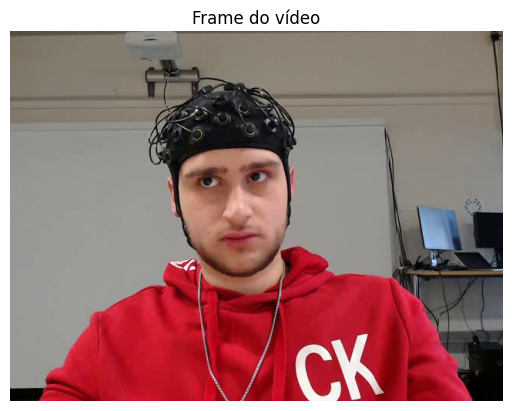

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Teste de leitura direta de vídeo
video_path = ".\Train\\video\\3\\3_Rest_3.mp4"  # Substituir com o caminho real
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
else:
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Converte BGR para RGB
        plt.title("Frame do vídeo")
        plt.axis("off")
        plt.show()
    else:
        print("Não foi possível ler o frame.")
cap.release()
